In [34]:
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import os
import pickle
from torchvision import transforms
import pytorch_lightning as pl
import torch

# load own code
import sys
sys.path.append('../')
from sleeplib.Resnet_15.model import FineTuning
from sleeplib.datasets import BonoboDataset, ContinousToSnippetDataset
# this holds all the configuration parameters
from sleeplib.config import Config
import pickle

from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import DataLoader
from torchvision import transforms

from sleeplib.datasets import BonoboDataset , ContinousToSnippetDataset
from sleeplib.montages import CDAC_bipolar_montage,CDAC_common_average_montage,CDAC_combine_montage,con_combine_montage
from sleeplib.transforms import cut_and_jitter, channel_flip


In [35]:
path_model = 'Models/YOUR_MODEL_NAME'
# load config file
with open(path_model+'/config.pkl', 'rb') as f:
   config = pickle.load(f)
# load dataset
df = pd.read_csv(config.PATH_LUT_BONOBO,sep=',')
# fraction filter
frac_filter = (df['fraction_of_yes'] > 6/8) | (df['fraction_of_yes'] < 2/8)
mode_filter = df['Mode'] == 'Test'
extreme_quality_filter = df['total_votes_received'] >= 8
quality_filter = df['total_votes_received'] > 2

test_df = df[mode_filter]
print(f'there are {len(test_df)} test samples')

KeyError: 'fraction_of_yes'

In [36]:
# set up dataloader to predict all samples in test dataset
transform_val = transforms.Compose([cut_and_jitter(windowsize=config.WINDOWSIZE,max_offset=0,Fq=config.FQ)])
combine_montage = CDAC_combine_montage()
con_combine_montage = con_combine_montage()

test_dataset = BonoboDataset(test_df, config.PATH_FILES_BONOBO, 
                           transform=transform_val,
                           montage = combine_montage
                          )
test_dataloader = DataLoader(test_dataset, batch_size=32,shuffle=False,num_workers=os.cpu_count())
for x, y in test_dataloader:
    with torch.no_grad():
        print(x.shape)
        print(y)
        break

'''
Bonobo_con = ContinousToSnippetDataset('/home/ubuntu/data/Bonobo01742_0.mat',montage=con_combine_montage)
con_dataloader = DataLoader(Bonobo_con, batch_size=config.BATCH_SIZE,shuffle=False,num_workers=os.cpu_count())

for x, y in con_dataloader:
    with torch.no_grad():
        print(x.shape)
        print(y)
        break
'''

torch.Size([32, 37, 384])
tensor([0.2500, 0.0000, 0.0000, 0.8750, 0.2500, 0.2500, 0.0000, 0.0667, 1.0000,
        0.1250, 0.2500, 0.2500, 0.0000, 0.2500, 0.1250, 0.1250, 0.2500, 0.8333,
        0.8889, 0.8333, 0.8000, 0.8000, 0.7500, 0.0000, 0.0000, 0.2222, 0.2500,
        0.7500, 0.2500, 0.1667, 0.0000, 0.1667], dtype=torch.float64)


"\nBonobo_con = ContinousToSnippetDataset('/home/ubuntu/data/Bonobo01742_0.mat',montage=con_combine_montage)\ncon_dataloader = DataLoader(Bonobo_con, batch_size=config.BATCH_SIZE,shuffle=False,num_workers=os.cpu_count())\n\nfor x, y in con_dataloader:\n    with torch.no_grad():\n        print(x.shape)\n        print(y)\n        break\n"

In [37]:
# load pretrained model
model = FineTuning.load_from_checkpoint('/home/ubuntu/code/Spike_37chan/Models/YOUR_MODEL_NAME/37chan_weights-v26.ckpt',
                                        lr=config.LR,
                                        head_dropout=config.HEAD_DROPOUT,
                                        n_channels=config.N_CHANNELS,
                                        n_fft=config.N_FFT,
                                        hop_length=config.HOP_LENGTH,
                                       )
                                        #map_location=torch.device('cpu') add this if running on CPU machine
# init trainer
trainer = pl.Trainer(fast_dev_run=False,enable_progress_bar=False)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [38]:
# predict all samples
preds = trainer.predict(model,test_dataloader)
preds = np.concatenate(preds)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [39]:
# store results
results = test_df[['event_file','fraction_of_yes','total_votes_received','Mode']].copy()
results['preds'] = preds
results.to_csv(path_model+'/predictions.csv',index=False)

In [25]:
'''
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import os
import pickle
from torchvision import transforms
import pytorch_lightning as pl
import torch

# load own code
import sys
sys.path.append('../')
from sleeplib.Resnet_15.model import FineTuning
from sleeplib.datasets import BonoboDataset, ContinousToSnippetDataset
# this holds all the configuration parameters
from sleeplib.config import Config
import pickle

from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import DataLoader
from torchvision import transforms

# store results
path_controls = os.path.join('/home/ubuntu/code/vergleicher/Judge/testset_controls.csv')
controls = pd.read_csv(path_controls)
for eeg_file, timesteps in zip(controls.eeg_file, controls.timesteps):
    path = '/home/ubuntu/data/bonobo/con/'+eeg_file+'.mat'
    Bonobo_con = ContinousToSnippetDataset(path,montage=con_combine_montage)
    con_dataloader = DataLoader(Bonobo_con, batch_size=32,shuffle=False,num_workers=os.cpu_count())
    
    preds = trainer.predict(model,con_dataloader)
    preds = np.concatenate(preds)
    
    preds = pd.DataFrame(preds)
    preds.to_csv(path_model+'/con/'+ eeg_file +'.csv',index=False)
    print(eeg_file)
'''    

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo03119_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07980_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08909_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11111_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07137_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08745_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08381_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10684_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo05995_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo01430_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo00007_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10983_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10649_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10602_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10709_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11145_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09154_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07626_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10448_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07941_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09618_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo04685_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07814_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09194_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo00700_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11553_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10243_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo04102_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09286_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo00831_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11412_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08108_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10875_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11478_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11272_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10642_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08556_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10304_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11139_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09454_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11095_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11508_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10129_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09030_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07158_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08100_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo03269_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07193_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09413_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11153_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11233_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08749_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09598_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo00432_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10126_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10289_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07701_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10733_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11199_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09065_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo01245_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07225_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07329_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09748_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09961_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10244_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09826_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07645_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07732_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09300_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07692_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09467_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10862_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo04850_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11418_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo06002_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07679_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo00613_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo02903_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11714_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09907_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10984_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10963_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11550_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11393_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07665_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10466_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11456_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10682_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11670_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10583_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09832_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09034_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08980_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11727_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08376_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07653_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10201_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11213_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10812_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11628_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11361_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09835_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10333_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08353_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo04392_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo06487_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07724_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo01240_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09243_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07712_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08516_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo05402_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07117_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10419_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08052_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo00332_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09913_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09582_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10836_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11018_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11470_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08895_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10104_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09256_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09658_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08600_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09732_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo00069_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08453_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07953_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09630_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07336_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10166_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08189_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08490_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08995_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08234_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08916_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10375_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07767_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07167_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08704_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11492_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08959_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09297_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10309_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11372_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10349_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08422_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11661_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08914_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09330_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07928_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09662_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo00133_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10295_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08373_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo02177_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09535_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10531_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo02255_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11557_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo06123_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08866_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08288_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10786_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09486_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11417_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09987_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07727_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08571_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10976_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10159_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09149_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07856_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11060_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10081_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11672_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09270_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo02531_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08352_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11104_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo00003_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09784_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10593_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08735_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09466_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08491_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10498_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11422_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10001_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo02611_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10428_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10283_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08591_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09078_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08217_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07343_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10406_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09856_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo05433_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo03553_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07636_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08123_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08097_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07783_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11443_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09580_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09081_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08322_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08370_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11683_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08445_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09225_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10203_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09541_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07394_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08274_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08807_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08639_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo05233_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10052_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08506_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11410_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10280_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09306_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10385_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07942_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11736_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11563_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11611_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10899_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08253_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11382_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo06001_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09937_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10260_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09458_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11235_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07504_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11201_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo03178_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10400_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11280_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07965_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09955_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08595_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo02568_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10671_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08567_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10057_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07371_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08565_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09765_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08702_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09216_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo03735_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08968_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08198_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10574_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10793_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09788_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08397_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09838_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11270_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09932_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09218_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11079_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11035_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07136_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07756_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10759_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo01010_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11264_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11436_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo03091_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10216_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11541_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10217_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09401_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10170_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08332_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07752_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10846_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07750_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07208_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07682_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo01361_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09537_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09877_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09462_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo00482_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09444_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09394_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08933_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07108_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo01434_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07408_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09220_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10485_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09005_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07691_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10606_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08605_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10536_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11339_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo03535_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07368_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07221_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09517_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11507_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10514_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11100_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08296_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10175_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10131_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10788_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08323_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09474_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08890_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10442_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10290_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09940_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10355_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo00862_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10259_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07227_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09634_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09864_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo04900_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo01339_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09575_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07697_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10416_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09382_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07809_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09685_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo05686_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo04917_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo05705_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09567_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo04522_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08886_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09762_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11345_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo01495_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08627_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07434_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08715_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo00452_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11375_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08705_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08810_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo04811_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08950_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo04514_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08202_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10974_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09111_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11514_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07766_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08065_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10960_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07269_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo05024_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11318_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08141_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10774_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10710_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07228_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07298_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09822_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10056_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10417_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10553_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09706_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11210_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09934_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09768_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10809_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo05935_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10143_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10932_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo02443_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09552_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11184_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11069_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo00297_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10552_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09568_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo03311_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10202_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10471_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09742_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo00740_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10293_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11389_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09870_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo05972_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo04273_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10925_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10834_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo02951_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09175_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09101_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08185_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07688_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07850_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08799_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08729_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07252_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10549_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07826_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10555_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08859_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11411_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo02316_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10357_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10628_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08770_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07709_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09211_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09358_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07420_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08540_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10829_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10252_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07660_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08846_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11407_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07244_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07135_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07425_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo03228_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07115_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo05877_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11708_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09887_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08171_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08117_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10209_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08620_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10118_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo05403_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo04566_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08392_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09750_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09479_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08576_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11082_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08554_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo05485_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11546_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08621_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07903_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07349_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07890_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08888_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11127_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09820_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09780_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09059_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09895_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10589_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11587_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10065_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09335_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09511_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11308_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10464_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07123_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11080_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10968_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo06224_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11254_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo01853_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08372_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10278_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07612_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10134_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07126_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07250_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08910_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07404_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08741_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09659_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09899_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09096_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11390_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09340_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10959_0
Bonobo05230_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07538_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09367_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08326_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11054_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10150_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11397_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08320_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11526_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11134_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09399_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11471_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09922_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo05497_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09136_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08626_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09414_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11359_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07929_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08871_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07943_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10519_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08358_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11078_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10155_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11677_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07518_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08109_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08999_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07640_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08608_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08226_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08930_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08467_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10412_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09445_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10839_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo01610_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08193_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07878_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo03357_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10393_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo05404_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08546_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09093_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo06047_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07832_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08035_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10811_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08016_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07573_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10721_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09860_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10178_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08018_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10541_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10002_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07900_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08782_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10892_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10336_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo00483_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07296_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11206_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo00505_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09278_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07616_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09169_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11216_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08345_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo02746_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10704_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07638_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11067_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08653_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11515_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09638_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10503_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10302_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo03521_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08913_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10570_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09251_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08037_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09008_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo01766_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08429_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08648_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08269_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo02886_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08663_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07614_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10297_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07107_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07845_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11573_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10248_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11715_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08594_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11212_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07717_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08982_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09199_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo02266_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07354_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10823_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09325_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09221_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11088_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08578_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09645_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07703_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09663_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo04027_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07572_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08828_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09188_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07318_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10338_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07704_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10085_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08835_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10144_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07870_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10227_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09738_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07960_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11475_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08300_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07944_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11107_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11056_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09215_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo03646_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09635_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07603_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo05970_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11383_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09951_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07265_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo00080_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07667_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo05356_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09409_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10426_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07369_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10751_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo01081_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11262_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo04987_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07621_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10767_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07507_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10430_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo01963_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10600_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08196_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07735_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10146_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07114_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10617_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09085_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11630_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07840_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10149_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08183_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07593_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09646_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08130_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo00688_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10215_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo03826_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10440_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo00018_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11401_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10857_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo05521_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo00961_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07637_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09564_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07806_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08617_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09210_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07835_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09905_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo01710_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11124_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10423_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07606_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08747_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10330_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07327_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10792_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09380_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09007_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09252_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08684_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09055_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo01986_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07302_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo05079_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10749_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo05577_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10864_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10819_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08560_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08107_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09407_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10863_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10374_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10848_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09966_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07402_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo01461_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08085_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08819_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08575_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07907_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08569_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07170_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09975_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11065_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07743_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10894_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10204_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11008_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07993_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08247_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09867_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11518_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09167_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07536_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09538_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo00047_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08444_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11698_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07427_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09110_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11750_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10945_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10267_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09092_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08613_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10228_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09651_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09228_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11177_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08254_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10082_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09642_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10961_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07994_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08673_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07323_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10509_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10547_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10985_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11741_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10262_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08406_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11077_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08159_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11058_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08263_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10383_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08869_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09372_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo06181_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07686_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10352_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07588_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10218_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08986_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo02904_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10294_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo00517_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10172_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08459_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08006_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10350_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08816_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10956_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09480_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo00316_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11725_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09362_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09484_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08231_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09769_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07904_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10312_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08759_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07543_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10934_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10557_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08114_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08979_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10434_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09594_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09162_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07950_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo04479_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11016_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07972_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo00989_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09477_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10605_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11322_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08311_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo03157_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo00593_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo00222_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11749_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11545_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07486_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09994_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo05676_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08781_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08489_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07868_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08382_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11186_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09850_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09022_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07174_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo00561_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07563_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08863_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10762_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07964_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07306_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo00273_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10367_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07180_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07962_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo01746_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09741_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09417_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07622_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09965_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09989_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo03045_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08091_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11159_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10659_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10696_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08583_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07706_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08811_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08526_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07111_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09043_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09573_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08241_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07447_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08726_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11583_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10994_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08587_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo01488_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo05241_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10347_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08184_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07197_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08570_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07503_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09316_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10787_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11237_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07557_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08983_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09015_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08265_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo05984_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09398_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo01395_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08932_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10595_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08669_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11575_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09279_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08598_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08120_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08668_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09588_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08361_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo02136_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10119_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07330_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo00895_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10454_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10540_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08302_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11462_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07669_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo02497_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10324_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09585_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10935_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11745_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08435_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10114_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07529_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11021_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07561_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07257_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07611_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09070_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08250_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10921_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07173_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10877_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11367_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10185_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09370_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08169_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08845_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10389_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09301_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11739_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo04675_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10298_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo01808_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07234_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11621_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08090_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10643_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10356_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08140_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo00137_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07277_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08223_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09950_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo01862_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09103_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10685_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo05851_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09619_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11535_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07562_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08154_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07585_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10148_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07160_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09020_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11666_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10598_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10940_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10335_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo03289_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo01622_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10756_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09275_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07921_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10107_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07346_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11465_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07722_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo04049_2


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07827_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11530_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09941_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07632_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09258_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10450_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08792_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08105_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo01480_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07872_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08557_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07607_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07664_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10130_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11092_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10266_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11040_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10133_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08834_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09923_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08279_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08025_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo01629_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08153_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08841_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08482_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07477_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09747_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo02323_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08211_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08019_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10232_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08349_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07510_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10981_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11286_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo07696_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11516_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo05540_1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11555_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11742_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09590_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo10955_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09322_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo09475_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo08806_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11455_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11229_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Bonobo11309_0


In [4]:
import scipy.io
import pandas as pd

# 加载 .mat 文件
mat_file_path = '/home/ubuntu/data/Bonobo_scores_afterRound3_spread_2023Jan31.mat'
mat_data = scipy.io.loadmat(mat_file_path)
print('1')
# 从 .mat 数据中提取一个变量
variable_name = 'your_variable_name'
data = mat_data['lut_pseudo']

# 将数据转换为 DataFrame
data_frame = pd.DataFrame(data)
print('2')

# 保存为 CSV 文件
csv_file_path = '/home/ubuntu/data/pseudo.csv'
data_frame.to_csv(csv_file_path, index=False)


1
2


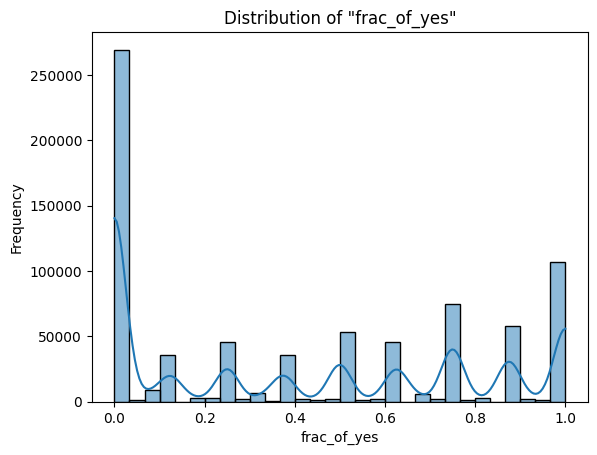

count    771512.000000
mean          0.412493
std           0.384477
min           0.000000
25%           0.000000
50%           0.375000
75%           0.750000
max           1.000000
Name: 7, dtype: float64

In [22]:
import pandas as pd
# Importing necessary libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# 指定CSV文件的路径
csv_file_path = '/home/ubuntu/data/pseudo.csv'

# 读取CSV文件
data = pd.read_csv(csv_file_path)

second_last_column = data.iloc[:, -2]

# 由于该列看起来包含在双重列表中，我们可能需要进行一些转换
second_last_column_values = second_last_column.apply(lambda x: eval(x)[0][0])


# Plotting the histogram for the 'preds' column
plt.figure
sns.histplot(second_last_column_values, bins=30, kde=True)
plt.title('Distribution of "frac_of_yes"')
plt.xlabel('frac_of_yes')
plt.ylabel('Frequency')
plt.show()

# Providing summary statistics for the 'preds' column
summary_statistics = second_last_column_values.describe()
summary_statistics

In [24]:
from collections import Counter
import re

third_last_column = data.iloc[:, -3]

# 定义一个函数，用于从字符串中提取所有的单词
def extract_words(text):
    # 使用正则表达式匹配单词
    return re.findall(r"'(\w+)'", text)

# 应用该函数提取倒数第三列中的所有单词
words_third_last_column = third_last_column.apply(extract_words)

# 合并所有的单词列表并统计频率
words_frequency = Counter([word for sublist in words_third_last_column for word in sublist])

# 将频率转换为 DataFrame，以便更好地展示
words_frequency_df = pd.DataFrame.from_dict(words_frequency, orient='index', columns=['Frequency']).reset_index()
words_frequency_df.rename(columns={'index': 'Word'}, inplace=True)

# 按频率降序排列
words_frequency_df = words_frequency_df.sort_values(by='Frequency', ascending=False)

# 显示前几个单词及其频率
words_frequency_df


,Word,Frequency
0,mbw,771512
3,jon,680472
6,ioannis,502269
7,marcus,502269
2,jj,401494


In [26]:
import pandas as pd

# Read the files
pseudo20_df = pd.read_csv('/home/ubuntu/data/pseudo.csv')

# Reading lut_labelled_20230628.csv with ; as delimiter

# Removing the unnecessary columns from pseudo20.csv
pseudo20_df = pseudo20_df[['event_file', 'fraction_of_yes', 'total_votes_received']]

# Cleaning the event_file column in pseudo20_df
pseudo20_df['event_file'] = pseudo20_df['event_file'].str.extract(r"['\[\]](.+?)['\[\]]")

pseudo20_df['event_file'] = pseudo20_df['event_file'].str.replace("'", "")
pseudo20_df['fraction_of_yes'] = pseudo20_df['fraction_of_yes'].str.extract(r"\[\[([\d\.]+)\]\]").astype(float)
pseudo20_df['total_votes_received'] = pseudo20_df['total_votes_received'].str.extract(r"\[\[(\d+)\]\]").astype(int)


In [28]:
import pandas as pd

# Read the files
pseudo20_df = pd.read_csv('/home/ubuntu/data/pseudo.csv')
# Clean the data as done previously
pseudo20_df = pseudo20_df[['event_file', 'fraction_of_yes', 'total_votes_received']]

# Extract the eeg_file data from event_file
pseudo20_df['eeg_file'] = pseudo20_df['event_file'].apply(lambda x: '_'.join(x.split('_')[:-1]))

# Preview the data with the new eeg_file column


pseudo20_df = pseudo20_df[['event_file', 'eeg_file', 'fraction_of_yes', 'total_votes_received']]
pseudo20_updated_head = pseudo20_df.head(20)
pseudo20_updated_head

,event_file,eeg_file,fraction_of_yes,total_votes_received
0,Bonobo00001_0_1023.mat,Bonobo00001_0,0.000000,4
1,Bonobo00001_0_1028.mat,Bonobo00001_0,1.000000,8
2,Bonobo00001_0_105.mat,Bonobo00001_0,0.000000,4
3,Bonobo00001_0_106.mat,Bonobo00001_0,0.000000,4
4,Bonobo00001_0_1085.mat,Bonobo00001_0,0.000000,18
5,Bonobo00001_0_1086.mat,Bonobo00001_0,0.666667,12
6,Bonobo00001_0_1101.mat,Bonobo00001_0,0.500000,8
7,Bonobo00001_0_114.mat,Bonobo00001_0,0.000000,4
8,Bonobo00001_0_115.mat,Bonobo00001_0,0.000000,4
9,Bonobo00001_0_1150.mat,Bonobo00001_0,0.000000,4


In [34]:
output_path = '/home/ubuntu/data/pseudo.csv'
pseudo20_df.to_csv(output_path, index=False)

In [24]:
pseudo20_df = pd.read_csv('/home/ubuntu/data/pseudo.csv')
pseudo20_updated_head = pseudo20_df.head(20)
pseudo20_updated_head

,event_file,fraction_of_yes,total_votes_received,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,['Bonobo00001_0_1023.mat'],[[0]],[[4]],NaN,NaN,NaN,NaN
1,['Bonobo00001_0_1028.mat'],[[1]],[[8]],NaN,NaN,NaN,NaN
2,['Bonobo00001_0_105.mat'],[[0]],[[4]],NaN,NaN,NaN,NaN
3,['Bonobo00001_0_106.mat'],[[0]],[[4]],NaN,NaN,NaN,NaN
4,['Bonobo00001_0_1085.mat'],[[0]],[[18]],NaN,NaN,NaN,NaN
5,['Bonobo00001_0_1086.mat'],[[0.66666667]],[[12]],NaN,NaN,NaN,NaN
6,['Bonobo00001_0_1101.mat'],[[0.5]],[[8]],NaN,NaN,NaN,NaN
7,['Bonobo00001_0_114.mat'],[[0]],[[4]],NaN,NaN,NaN,NaN
8,['Bonobo00001_0_115.mat'],[[0]],[[4]],NaN,NaN,NaN,NaN
9,['Bonobo00001_0_1150.mat'],[[0]],[[4]],NaN,NaN,NaN,NaN


In [30]:
import numpy as np

# Unique eeg_files
unique_eeg_files = pseudo20_df['eeg_file'].unique()

# Determine the number of eeg_files that should be labeled "Train" and "Val"
num_train = int(len(unique_eeg_files) * 8 / 9)
num_val = len(unique_eeg_files) - num_train

# Randomly assign "Train" or "Val" to each unique eeg_file based on the given ratio
np.random.seed(42)  # Setting a seed for reproducibility
labels = np.array(['Train'] * num_train + ['Val'] * num_val)
np.random.shuffle(labels)

# Create a mapping of eeg_file to the assigned label
eeg_file_to_mode = dict(zip(unique_eeg_files, labels))

# Map this to the dataframe to create the Mode column
pseudo20_df['Mode'] = pseudo20_df['eeg_file'].map(eeg_file_to_mode)

# Preview the updated dataframe
pseudo20_with_mode_head = pseudo20_df.head(20)
pseudo20_with_mode_head

,event_file,eeg_file,fraction_of_yes,total_votes_received,Mode
0,Bonobo00001_0_1023.mat,Bonobo00001_0,0.000000,4,Train
1,Bonobo00001_0_1028.mat,Bonobo00001_0,1.000000,8,Train
2,Bonobo00001_0_105.mat,Bonobo00001_0,0.000000,4,Train
3,Bonobo00001_0_106.mat,Bonobo00001_0,0.000000,4,Train
4,Bonobo00001_0_1085.mat,Bonobo00001_0,0.000000,18,Train
5,Bonobo00001_0_1086.mat,Bonobo00001_0,0.666667,12,Train
6,Bonobo00001_0_1101.mat,Bonobo00001_0,0.500000,8,Train
7,Bonobo00001_0_114.mat,Bonobo00001_0,0.000000,4,Train
8,Bonobo00001_0_115.mat,Bonobo00001_0,0.000000,4,Train
9,Bonobo00001_0_1150.mat,Bonobo00001_0,0.000000,4,Train


In [33]:
predictions_df = pd.read_csv('/home/ubuntu/data/predictions.csv')

# Extract the eeg_file data from the event_file column in predictions.csv
predictions_df['eeg_file'] = predictions_df['event_file'].apply(lambda x: '_'.join(x.split('_')[:-1]))

# Extract the eeg_file column from predictions.csv
eeg_files_to_remove = predictions_df['eeg_file'].unique()

# Filter out rows in pseudo20_df that have eeg_file values present in eeg_files_to_remove
filtered_pseudo20_df = pseudo20_df[~pseudo20_df['eeg_file'].isin(eeg_files_to_remove)]

# Preview the filtered dataframe
filtered_pseudo20_head = filtered_pseudo20_df.head(20)
filtered_pseudo20_head


,event_file,eeg_file,fraction_of_yes,total_votes_received,Mode
0,Bonobo00001_0_1023.mat,Bonobo00001_0,0.000000,4,Train
1,Bonobo00001_0_1028.mat,Bonobo00001_0,1.000000,8,Train
2,Bonobo00001_0_105.mat,Bonobo00001_0,0.000000,4,Train
3,Bonobo00001_0_106.mat,Bonobo00001_0,0.000000,4,Train
4,Bonobo00001_0_1085.mat,Bonobo00001_0,0.000000,18,Train
5,Bonobo00001_0_1086.mat,Bonobo00001_0,0.666667,12,Train
6,Bonobo00001_0_1101.mat,Bonobo00001_0,0.500000,8,Train
7,Bonobo00001_0_114.mat,Bonobo00001_0,0.000000,4,Train
8,Bonobo00001_0_115.mat,Bonobo00001_0,0.000000,4,Train
9,Bonobo00001_0_1150.mat,Bonobo00001_0,0.000000,4,Train


In [42]:
import pandas as pd

# 1. Read the pseudo.csv file
pseudo_df = pd.read_csv('/home/ubuntu/data/pseudo.csv', sep=",")

# 2. Replace commas with semicolons in the dataframe
pseudo_df = pseudo_df.replace(',', ';', regex=True)

# 3. Swap the total_votes_received and fraction_of_yes columns
pseudo_df = pseudo_df[['event_file', 'fraction_of_yes', 'total_votes_received','eeg_file','Mode']]

# 4. Remove the '.mat' from the event_file column
pseudo_df['event_file'] = pseudo_df['event_file'].str.replace('.mat', '')

# 5. Read the lut.csv file
lut_df = pd.read_csv("/home/ubuntu/code/Spike_37chan/lut_labelled_20230628.csv", sep=";")

# 6. Concatenate the modified pseudo.csv with lut.csv
combined_df = pd.concat([pseudo_df, lut_df], ignore_index=True)

# 7. Preview the concatenated dataframe
combined_df_head = combined_df.head(20)
combined_df_head

,event_file,fraction_of_yes,total_votes_received,eeg_file,Mode
0,Bonobo00001_0_1023,0.000000,4,Bonobo00001_0,Train
1,Bonobo00001_0_1028,1.000000,8,Bonobo00001_0,Train
2,Bonobo00001_0_105,0.000000,4,Bonobo00001_0,Train
3,Bonobo00001_0_106,0.000000,4,Bonobo00001_0,Train
4,Bonobo00001_0_1085,0.000000,18,Bonobo00001_0,Train
5,Bonobo00001_0_1086,0.666667,12,Bonobo00001_0,Train
6,Bonobo00001_0_1101,0.500000,8,Bonobo00001_0,Train
7,Bonobo00001_0_114,0.000000,4,Bonobo00001_0,Train
8,Bonobo00001_0_115,0.000000,4,Bonobo00001_0,Train
9,Bonobo00001_0_1150,0.000000,4,Bonobo00001_0,Train


In [41]:
output_path = '/home/ubuntu/code/Spike_37chan/pseudo.csv'
combined_df.to_csv(output_path, index=False)

In [2]:
path_model = 'Models/YOUR_MODEL_NAME'
# load config file
with open(path_model+'/config.pkl', 'rb') as f:
   config = pickle.load(f)
# load dataset
df = pd.read_csv(config.PATH_LUT_BONOBO,sep=';')

# 对“fraction_of_yes”列进行处理
df.loc[df['fraction_of_yes'] > 0.7, 'fraction_of_yes'] = 1
df.loc[df['fraction_of_yes'] < 0.3, 'fraction_of_yes'] = 0

# 删除在0.3和0.7之间的行
df = df[(df['fraction_of_yes'] == 1) | (df['fraction_of_yes'] == 0)]

output_path = '/home/ubuntu/code/Spike_37chan/hard_label.csv'
df.to_csv(output_path, index=False)

In [13]:
path_model = 'Models/YOUR_MODEL_NAME'
# load config file
with open(path_model+'/config.pkl', 'rb') as f:
   config = pickle.load(f)
# load dataset
df = pd.read_csv(config.PATH_LUT_BONOBO,sep=';')
df_filtered = df[(df['fraction_of_yes'] <= 0.3) | (df['fraction_of_yes'] >= 0.7)]
output_path = '/home/ubuntu/code/Spike_37chan/soft_label.csv'
df_filtered.to_csv(output_path, index=False)

KeyError: 'fraction_of_yes'